In [7]:
import os

import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [8]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

json_path = '../data/arxiv-metadata-oai-snapshot.json'
if not os.path.exists(json_path):
    raise FileNotFoundError(f"Please download the arXiv metadata from {json_path}")

load_existing = True
parquet_path = '../data/arxiv_metadata.parquet.gzip'

## Process json

In [9]:
# load json into pandas dataframe in chunks and only keep the relevant columns
if load_existing and os.path.exists(parquet_path):
    print(f"Loading existing parquet file from {parquet_path}")
    data_df = pd.read_parquet(parquet_path, engine='pyarrow')
    display(data_df.head(2), data_df.tail(2))
    print(f"Loaded {len(data_df)} rows")
else:
    columns_to_keep = ['id', 'title', 'abstract', 'categories', 'update_date']
    dtypes = {'id': str, 'title': str, 'abstract': str, 'categories': str, 'update_date': str}
    chunksize = 100_000
    reader = pd.read_json(json_path, lines=True, chunksize=chunksize)

    data_to_keep = []
    for i, chunk in enumerate(reader):
        print(f"Processing chunk {i} - so far {len(data_to_keep) * chunksize} rows")
        data_to_keep.append(chunk[columns_to_keep].to_dict(orient='records'))
    data_to_keep = [item for sublist in data_to_keep for item in sublist]
    new_df = pd.DataFrame(data_to_keep).reset_index(drop=True)
    for col in columns_to_keep:
        new_df[col] = new_df[col].astype(dtypes[col])
    del data_to_keep

    display(new_df.head(2), new_df.tail(2))

    new_df.to_parquet(parquet_path, compression='gzip', engine='pyarrow')

Loading existing parquet file from ../data/arxiv_metadata.parquet.gzip


,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13


,id,title,abstract,categories,update_date
2477301,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,We show that the density of states in an ani...,supr-con cond-mat.supr-con,2009-10-30
2477302,supr-con/9609004,Ginzburg Landau theory for d-wave pairing and ...,The Ginzburg Landau theory for d_{x^2-y^2}-w...,supr-con cond-mat.supr-con,2009-10-30


Loaded 2477303 rows


## EDA

In [10]:
# https://arxiv.org/category_taxonomy
category_map = {
    # These created errors when mapping categories to descriptions
    "acc-phys": "Accelerator Physics",
    "adap-org": "Not available",
    "q-bio": "Not available",
    "cond-mat": "Not available",
    "chao-dyn": "Not available",
    "patt-sol": "Not available",
    "dg-ga": "Not available",
    "solv-int": "Not available",
    "bayes-an": "Not available",
    "comp-gas": "Not available",
    "alg-geom": "Not available",
    "funct-an": "Not available",
    "q-alg": "Not available",
    "ao-sci": "Not available",
    "atom-ph": "Atomic Physics",
    "chem-ph": "Chemical Physics",
    "plasm-ph": "Plasma Physics",
    "mtrl-th": "Not available",
    "cmp-lg": "Not available",
    "supr-con": "Not available",
    ###
    # Added
    "econ.GN": "General Economics",
    "econ.TH": "Theoretical Economics",
    "eess.SY": "Systems and Control",
    "astro-ph": "Astrophysics",
    "astro-ph.CO": "Cosmology and Nongalactic Astrophysics",
    "astro-ph.EP": "Earth and Planetary Astrophysics",
    "astro-ph.GA": "Astrophysics of Galaxies",
    "astro-ph.HE": "High Energy Astrophysical Phenomena",
    "astro-ph.IM": "Instrumentation and Methods for Astrophysics",
    "astro-ph.SR": "Solar and Stellar Astrophysics",
    "cond-mat.dis-nn": "Disordered Systems and Neural Networks",
    "cond-mat.mes-hall": "Mesoscale and Nanoscale Physics",
    "cond-mat.mtrl-sci": "Materials Science",
    "cond-mat.other": "Other Condensed Matter",
    "cond-mat.quant-gas": "Quantum Gases",
    "cond-mat.soft": "Soft Condensed Matter",
    "cond-mat.stat-mech": "Statistical Mechanics",
    "cond-mat.str-el": "Strongly Correlated Electrons",
    "cond-mat.supr-con": "Superconductivity",
    "cs.AI": "Artificial Intelligence",
    "cs.AR": "Hardware Architecture",
    "cs.CC": "Computational Complexity",
    "cs.CE": "Computational Engineering, Finance, and Science",
    "cs.CG": "Computational Geometry",
    "cs.CL": "Computation and Language",
    "cs.CR": "Cryptography and Security",
    "cs.CV": "Computer Vision and Pattern Recognition",
    "cs.CY": "Computers and Society",
    "cs.DB": "Databases",
    "cs.DC": "Distributed, Parallel, and Cluster Computing",
    "cs.DL": "Digital Libraries",
    "cs.DM": "Discrete Mathematics",
    "cs.DS": "Data Structures and Algorithms",
    "cs.ET": "Emerging Technologies",
    "cs.FL": "Formal Languages and Automata Theory",
    "cs.GL": "General Literature",
    "cs.GR": "Graphics",
    "cs.GT": "Computer Science and Game Theory",
    "cs.HC": "Human-Computer Interaction",
    "cs.IR": "Information Retrieval",
    "cs.IT": "Information Theory",
    "cs.LG": "Machine Learning",
    "cs.LO": "Logic in Computer Science",
    "cs.MA": "Multiagent Systems",
    "cs.MM": "Multimedia",
    "cs.MS": "Mathematical Software",
    "cs.NA": "Numerical Analysis",
    "cs.NE": "Neural and Evolutionary Computing",
    "cs.NI": "Networking and Internet Architecture",
    "cs.OH": "Other Computer Science",
    "cs.OS": "Operating Systems",
    "cs.PF": "Performance",
    "cs.PL": "Programming Languages",
    "cs.RO": "Robotics",
    "cs.SC": "Symbolic Computation",
    "cs.SD": "Sound",
    "cs.SE": "Software Engineering",
    "cs.SI": "Social and Information Networks",
    "cs.SY": "Systems and Control",
    "econ.EM": "Econometrics",
    "eess.AS": "Audio and Speech Processing",
    "eess.IV": "Image and Video Processing",
    "eess.SP": "Signal Processing",
    "gr-qc": "General Relativity and Quantum Cosmology",
    "hep-ex": "High Energy Physics - Experiment",
    "hep-lat": "High Energy Physics - Lattice",
    "hep-ph": "High Energy Physics - Phenomenology",
    "hep-th": "High Energy Physics - Theory",
    "math.AC": "Commutative Algebra",
    "math.AG": "Algebraic Geometry",
    "math.AP": "Analysis of PDEs",
    "math.AT": "Algebraic Topology",
    "math.CA": "Classical Analysis and ODEs",
    "math.CO": "Combinatorics",
    "math.CT": "Category Theory",
    "math.CV": "Complex Variables",
    "math.DG": "Differential Geometry",
    "math.DS": "Dynamical Systems",
    "math.FA": "Functional Analysis",
    "math.GM": "General Mathematics",
    "math.GN": "General Topology",
    "math.GR": "Group Theory",
    "math.GT": "Geometric Topology",
    "math.HO": "History and Overview",
    "math.IT": "Information Theory",
    "math.KT": "K-Theory and Homology",
    "math.LO": "Logic",
    "math.MG": "Metric Geometry",
    "math.MP": "Mathematical Physics",
    "math.NA": "Numerical Analysis",
    "math.NT": "Number Theory",
    "math.OA": "Operator Algebras",
    "math.OC": "Optimization and Control",
    "math.PR": "Probability",
    "math.QA": "Quantum Algebra",
    "math.RA": "Rings and Algebras",
    "math.RT": "Representation Theory",
    "math.SG": "Symplectic Geometry",
    "math.SP": "Spectral Theory",
    "math.ST": "Statistics Theory",
    "math-ph": "Mathematical Physics",
    "nlin.AO": "Adaptation and Self-Organizing Systems",
    "nlin.CD": "Chaotic Dynamics",
    "nlin.CG": "Cellular Automata and Lattice Gases",
    "nlin.PS": "Pattern Formation and Solitons",
    "nlin.SI": "Exactly Solvable and Integrable Systems",
    "nucl-ex": "Nuclear Experiment",
    "nucl-th": "Nuclear Theory",
    "physics.acc-ph": "Accelerator Physics",
    "physics.ao-ph": "Atmospheric and Oceanic Physics",
    "physics.app-ph": "Applied Physics",
    "physics.atm-clus": "Atomic and Molecular Clusters",
    "physics.atom-ph": "Atomic Physics",
    "physics.bio-ph": "Biological Physics",
    "physics.chem-ph": "Chemical Physics",
    "physics.class-ph": "Classical Physics",
    "physics.comp-ph": "Computational Physics",
    "physics.data-an": "Data Analysis, Statistics and Probability",
    "physics.ed-ph": "Physics Education",
    "physics.flu-dyn": "Fluid Dynamics",
    "physics.gen-ph": "General Physics",
    "physics.geo-ph": "Geophysics",
    "physics.hist-ph": "History and Philosophy of Physics",
    "physics.ins-det": "Instrumentation and Detectors",
    "physics.med-ph": "Medical Physics",
    "physics.optics": "Optics",
    "physics.plasm-ph": "Plasma Physics",
    "physics.pop-ph": "Popular Physics",
    "physics.soc-ph": "Physics and Society",
    "physics.space-ph": "Space Physics",
    "q-bio.BM": "Biomolecules",
    "q-bio.CB": "Cell Behavior",
    "q-bio.GN": "Genomics",
    "q-bio.MN": "Molecular Networks",
    "q-bio.NC": "Neurons and Cognition",
    "q-bio.OT": "Other Quantitative Biology",
    "q-bio.PE": "Populations and Evolution",
    "q-bio.QM": "Quantitative Methods",
    "q-bio.SC": "Subcellular Processes",
    "q-bio.TO": "Tissues and Organs",
    "q-fin.CP": "Computational Finance",
    "q-fin.EC": "Economics",
    "q-fin.GN": "General Finance",
    "q-fin.MF": "Mathematical Finance",
    "q-fin.PM": "Portfolio Management",
    "q-fin.PR": "Pricing of Securities",
    "q-fin.RM": "Risk Management",
    "q-fin.ST": "Statistical Finance",
    "q-fin.TR": "Trading and Market Microstructure",
    "quant-ph": "Quantum Physics",
    "stat.AP": "Applications",
    "stat.CO": "Computation",
    "stat.ME": "Methodology",
    "stat.ML": "Machine Learning",
    "stat.OT": "Other Statistics",
    "stat.TH": "Statistics Theory",
}

In [11]:
data_df.head(3)

,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,2008-01-13


In [12]:
data_df['title_words'] = data_df['title'].apply(lambda x: len(x.split()))
data_df['abstract_words'] = data_df['abstract'].apply(lambda x: len(x.split()))
data_df['categories'] = data_df['categories'].apply(lambda x: x.split())
data_df['mapped_categories'] = data_df['categories'].apply(lambda x: [category_map[cat] if cat in category_map else "UNKNOWN" for cat in x])
data_df['amount_categories'] = data_df['categories'].apply(lambda x: len(x))
data_df['update_year'] = data_df['update_date'].apply(lambda x: int(x[:4]))
data_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,[hep-ph],2008-11-26,12,140,[High Energy Physics - Phenomenology],1,2008
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...","[math.CO, cs.CG]",2008-12-13,3,115,"[Combinatorics, Computational Geometry]",2,2008
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,[physics.gen-ph],2008-01-13,14,144,[General Physics],1,2008


In [13]:
print(f'Max number of words in title: {data_df["title_words"].max()}')
print(f'Max number of words in abstract: {data_df["abstract_words"].max()}')
print("-" * 50)
print(f'Min number of words in title: {data_df["title_words"].min()}')
print(f'Min number of words in abstract: {data_df["abstract_words"].min()}')
print("-" * 50)
print(f'Mean number of words in title: {data_df["title_words"].mean()}')
print(f'Mean number of words in abstract: {data_df["abstract_words"].mean()}')
print("-" * 50)
print(f'Median number of words in title: {data_df["title_words"].median()}')
print(f'Median number of words in abstract: {data_df["abstract_words"].median()}')

Max number of words in title: 61
Max number of words in abstract: 925
--------------------------------------------------
Min number of words in title: 1
Min number of words in abstract: 1
--------------------------------------------------
Mean number of words in title: 9.751281534798125
Mean number of words in abstract: 140.6586021168989
--------------------------------------------------
Median number of words in title: 9.0
Median number of words in abstract: 135.0


<Axes: xlabel='title_words', ylabel='Count'>

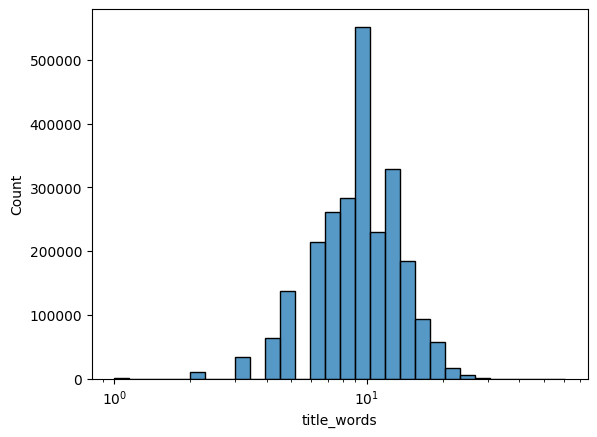

In [14]:
# histogram of number of words in titles and abstracts
sns.histplot(data_df['title_words'], bins=30, log_scale=True)

<Axes: xlabel='abstract_words', ylabel='Count'>

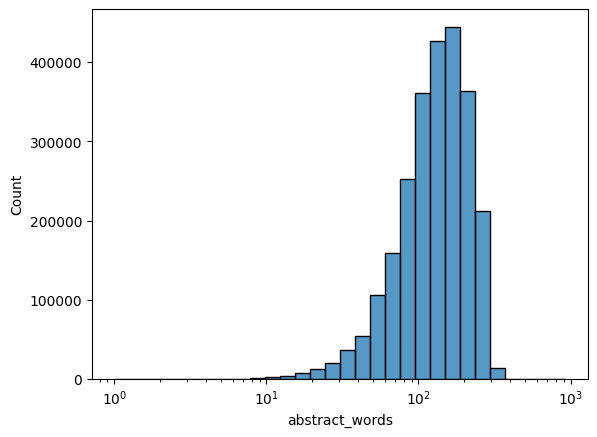

In [15]:
sns.histplot(data_df['abstract_words'], bins=30, log_scale=True)

In [16]:
abtract_words_dist = data_df['abstract_words'].value_counts().sort_values(ascending=False)
display(abtract_words_dist.head(3), abtract_words_dist.tail(3))
show_n = 10
for n in range(1, show_n + 1):
    print(f"Only {n} words in abstract: {abtract_words_dist[n]} times")

abstract_words
150    16475
100    15456
149    15417
Name: count, dtype: int64

abstract_words
497    1
487    1
458    1
Name: count, dtype: int64

Only 1 words in abstract: 4 times
Only 2 words in abstract: 31 times
Only 3 words in abstract: 43 times
Only 4 words in abstract: 66 times
Only 5 words in abstract: 246 times
Only 6 words in abstract: 110 times
Only 7 words in abstract: 218 times
Only 8 words in abstract: 427 times
Only 9 words in abstract: 386 times
Only 10 words in abstract: 531 times


In [17]:
# plot number of papers per year
data_df['update_year'].value_counts().sort_index()

update_year
2007    145833
2008     69325
2009    229015
2010     56175
2011     61794
2012     57222
2013     71838
2014     87847
2015    214639
2016    133303
2017    122202
2018    135646
2019    154632
2020    175299
2021    188606
2022    196471
2023    249061
2024    128395
Name: count, dtype: int64

In [18]:
# histogram for mapped categories (list of categories per paper)
category_counts = data_df['mapped_categories'].explode().value_counts().sort_values(ascending=False)

# print for all categories the amount, the percentage of total papers
for i, (cat, count) in enumerate(category_counts.items(), 1):
    print(f"[{i}] {cat}: {count} ({count / len(data_df) * 100:.2f}%)")

[1] Machine Learning: 238909 (9.64%)
[2] High Energy Physics - Phenomenology: 179237 (7.24%)
[3] High Energy Physics - Theory: 165608 (6.69%)
[4] Mathematical Physics: 157842 (6.37%)
[5] Quantum Physics: 147273 (5.94%)
[6] Computer Vision and Pattern Recognition: 122355 (4.94%)
[7] General Relativity and Quantum Cosmology: 106566 (4.30%)
[8] Astrophysics: 105380 (4.25%)
[9] Information Theory: 92918 (3.75%)
[10] Materials Science: 91373 (3.69%)
[11] Mesoscale and Nanoscale Physics: 89416 (3.61%)
[12] Artificial Intelligence: 88675 (3.58%)
[13] Strongly Correlated Electrons: 73199 (2.95%)
[14] Statistical Mechanics: 72906 (2.94%)
[15] Cosmology and Nongalactic Astrophysics: 66729 (2.69%)
[16] Combinatorics: 65317 (2.64%)
[17] Astrophysics of Galaxies: 63450 (2.56%)
[18] Computation and Language: 61702 (2.49%)
[19] Analysis of PDEs: 61350 (2.48%)
[20] Numerical Analysis: 60942 (2.46%)
[21] Solar and Stellar Astrophysics: 59666 (2.41%)
[22] High Energy Astrophysical Phenomena: 56943 (2.30

In [19]:
amount_categories_per_paper = data_df['amount_categories'].value_counts().sort_index()
for amount, count in amount_categories_per_paper.items():
    print(f"Paper with {amount} categories: {count}")

Paper with 1 categories: 1327729
Paper with 2 categories: 730544
Paper with 3 categories: 291723
Paper with 4 categories: 94134
Paper with 5 categories: 26452
Paper with 6 categories: 5685
Paper with 7 categories: 839
Paper with 8 categories: 147
Paper with 9 categories: 33
Paper with 10 categories: 14
Paper with 11 categories: 2
Paper with 13 categories: 1


In [83]:
n_samples = 500_000
samples_per_category = n_samples // len(category_map.values())
print(f"Sampling {samples_per_category} papers per category for {n_samples} samples")

sampled_data = []
for cat, count in category_counts.items():
    if count < samples_per_category:
        sampled_data.append(data_df[data_df['mapped_categories'].apply(lambda x: cat in x)])
    else:
        sampled_data.append(data_df[data_df['mapped_categories'].apply(lambda x: cat in x)].sample(samples_per_category, random_state=42))
sampled_df = pd.concat(sampled_data).sample(frac=1, random_state=42).reset_index(drop=True)

Sampling 2840 papers per category for 500000 samples


In [84]:
sampled_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,cond-mat/0401527,Dynamical interplay between local connectivity...,"We show, both numerically and analytically, ...","[cond-mat.dis-nn, cond-mat.soft, q-bio.PE]",2007-05-23,12,56,"[Disordered Systems and Neural Networks, Soft ...",3,2007
1,1508.07807,A coherence theorem for pseudonatural transfor...,We prove coherence theorems for bicategories...,[math.CT],2016-12-21,6,78,[Category Theory],1,2016
2,2102.04717,Development of astronomy research and educatio...,Africa has amazing potential due to natural ...,"[astro-ph.IM, physics.ed-ph]",2022-01-05,10,154,"[Instrumentation and Methods for Astrophysics,...",2,2022


In [85]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"Title: {title} - Abstract: {abstract}"

In [86]:
sampled_df['text'] = sampled_df.apply(text_processing, axis=1)

## Model Exploration

### all-MiniLM-L6-v2

In [87]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', cache_folder=cache_dir)
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', cache_folder=cache_dir)

w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [88]:
embeddings = model.encode(sampled_df['text'].tolist(), show_progress_bar=True, device='cuda', batch_size=256, normalize_embeddings=True)

Batches:   0%|          | 0/1603 [00:00<?, ?it/s]

In [89]:
query = "Deep Learning for Orca Detection in Underwater Sound Recordings"
query_embedding = model.encode(query, show_progress_bar=True, device='cuda', normalize_embeddings=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# we just normalized the embeddings, so the dot product is the cosine similarity (and its faster to compute)
import numpy as np

dot_products = np.dot(embeddings, query_embedding.squeeze())
top_k = 5
words_per_line = 25
top_k_indices = np.argsort(dot_products)[::-1][:top_k]

for i, idx in enumerate(top_k_indices, 1):
    print(f"[{i}] | Similarity: {dot_products[idx]:.2f}")
    text = sampled_df.loc[idx, 'text'].split()
    for j in range(0, len(text), words_per_line):
        print(" ".join(text[j:j + words_per_line]))
    print("-" * 50)

[1] | Similarity: 0.64
Title: An Features Extraction and Recognition Method for Underwater Acoustic Target Based on ATCNN - Abstract: Facing the complex marine environment, it is extremely challenging
to conduct underwater acoustic target recognition (UATR) using ship-radiated noise. Inspired by neural mechanism of auditory perception, this paper provides a new deep neural network
trained by original underwater acoustic signals with depthwise separable convolution (DWS) and time-dilated convolution neural network, named auditory perception inspired time-dilated convolution neural network (ATCNN),
and then implements detection and classification for underwater acoustic signals. The proposed ATCNN model consists of learnable features extractor and integration layer inspired by auditory
perception, and time-dilated convolution inspired by language model. This paper decomposes original time-domain ship-radiated noise signals into different frequency components with depthwise separable conv

In [91]:
# show tsne plot for the embeddings and the query with seaborn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=30, n_iter=1000, verbose=1)
X_embedded = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], alpha=0.5)
plt.scatter(X_embedded[top_k_indices, 0], X_embedded[top_k_indices, 1], color='red', s=100, label='Top 5')
plt.scatter(tsne.transform(query_embedding).squeeze()[0], tsne.transform(query_embedding).squeeze()[1], color='green', s=100, label='Query')
plt.legend()
plt.show()

: 

: 

In [ ]:
model_path = 'Alibaba-NLP/gte-large-en-v1.5'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float16 if device == 'cuda' else torch.float32
tokenizer = AutoTokenizer.from_pretrained(model_path, cache_dir=cache_dir)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, cache_dir=cache_dir)

model = model.to(device).eval().half() if torch_dtype == torch.float16 else model.to(device).eval()

In [ ]:
batch_size = 64
num_samples = 20_000

samples = df.sample(num_samples)
sample_abstracts = samples['abstract'].tolist()
sample_titles = samples['title'].tolist()

# sample_texts = [f'Title: {title.strip()} Abstract: {abstract.strip()}'.strip().replace('\n', ' ') for title, abstract in zip(sample_titles, sample_abstracts)]
sample_texts = [f'Title: {title.strip()}'.strip().replace('\n', ' ') for title, abstract in zip(sample_titles, sample_abstracts)]

In [ ]:
text_embeddings = []

for i in tqdm(range(0, num_samples, batch_size)):
    batch = sample_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=8192)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0].detach().to('cpu').float()
    embeddings = F.normalize(embeddings, p=2, dim=1)
    text_embeddings.append(embeddings)

text_embeddings = torch.cat(text_embeddings).cpu().numpy()
print(text_embeddings.shape)

In [ ]:
# take random sample of text (and corresponding embeddings) and calculate cosine similarity to all other text embeddings
# show the top 3 most similar text embeddings and their corresponding text and the 3 least similar text embeddings and their corresponding text
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
sample_idx = np.random.randint(0, num_samples)
sample_embedding = text_embeddings[sample_idx]
sample_text = sample_texts[sample_idx]
print(sample_text)

cosine_similarities = text_embeddings @ sample_embedding
sorted_indices = np.argsort(cosine_similarities)

print('Most similar')
for idx in sorted_indices[-4:-1]:
    print(sample_texts[idx], cosine_similarities[idx])

print('\nLeast similar')
for idx in sorted_indices[:3]:
    print(sample_texts[idx], cosine_similarities[idx])

In [ ]:
input_text = "Machine learning for computer vision"
tokenized_input = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=8192)
tokenized_input = {k: v.to(device) for k, v in tokenized_input.items()}
with torch.no_grad():
    output = model(**tokenized_input)
embedding = output.last_hidden_state[:, 0].detach().to('cpu').float()
embedding = F.normalize(embedding, p=2, dim=1).squeeze()

cosine_similarities = text_embeddings @ embedding.numpy()

sorted_indices = np.argsort(cosine_similarities)
print('Most similar')
for idx in sorted_indices[-4:-1]:
    print(sample_texts[idx], cosine_similarities[idx])

print('\nLeast similar')
for idx in sorted_indices[:3]:
    print(sample_texts[idx], cosine_similarities[idx])

In [ ]:
# create a interactive graph with all the text embeddings using TSNE and on hover show the text
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.manifold import TSNE

print('Calculating TSNE embeddings')
tsne = TSNE(n_components=2, perplexity=50, n_iter=1500, random_state=42)
tsne_embeddings = tsne.fit_transform(text_embeddings)

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, PanTool, WheelZoomTool
from bokeh.palettes import Category10
from bokeh.plotting import figure, output_notebook, show

# Prepare the data source
source = ColumnDataSource(data=dict(
    x=tsne_embeddings[:, 0],
    y=tsne_embeddings[:, 1],
    text=sample_texts
))

# Define hover tool
hover = HoverTool(tooltips=[("Text", "@text")])

# Create the plot
plot_title = "Text Embeddings"
plot_width = 800
plot_height = 600
p = figure(tools=[hover, WheelZoomTool(), PanTool()], title=plot_title, width=plot_width, height=plot_height)
p.circle('x', 'y', size=8, source=source, color=Category10[10][0], alpha=0.8, legend_label="Text Embeddings")

# Customize plot appearance
p.title.text_font_size = "16pt"
p.xaxis.axis_label = "TSNE Dimension 1"
p.yaxis.axis_label = "TSNE Dimension 2"
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"
p.xaxis.major_label_text_font_size = "12pt"
p.yaxis.major_label_text_font_size = "12pt"
p.legend.label_text_font_size = "12pt"
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Show the plot in the notebook
output_notebook()
show(p)